### categorize data by label

In [8]:
activities = ['Walking', 'Running', 'Commute in bus', 'Eating using fork and spoon', 
             'Using mobile phone(texting)', 'Working on laptop', 'Sitting', 'Washing hands',
             'Eating with hand', 'Conversing while sitting', 'Elevator', 'Opening door',
             'Standing', 'Climbing upstairs', 'Running']
columns = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Label']

In [9]:
import glob
import pandas as pd
def categorize():
    files = glob.glob("../DataSet/*Accelerometer.csv")
    data = pd.DataFrame()
    for name in files:
        data = data.append(pd.read_csv(name, usecols = columns))
    for i in range(len(activities)):
        tmp = data.loc[data['Label'] == i]
        tmp.to_csv("./categorized_data/" + activities[i] + ".csv", index=False)
# categorize()

In [10]:
def get_raw_data(activity):
    return pd.read_csv("./categorized_data/" + activity + ".csv")

### create segments with duration default 5

In [11]:
from tqdm import tqdm
def totoal_a(accs):
    import numpy as np
#     for i in range(len(accs)):
#         accs[i] = (accs[i]  * 3.0 / 63.0 - 1.5) * 9.8
    return np.sqrt(np.sum(map(lambda x: np.square(x), accs)))
    
def create_segs(data, duration):
    data = data.iloc[:, :3] # get x, y, z acceleration
    result = []
    for index, row in data.iterrows():
        result.append(totoal_a(list(row)[:3]))
    segs = []
    length = len(result)
    for i in tqdm(range(0, length, 32 * duration)):
        if i + duration * 32 <= length:
            segs.append(result[i:i + duration * 32])
    return segs

### calculate the medoid value
with the calculation of the distance of all the segementations, use fast relaxed dtw

In [12]:
# assume that each segment length is 5 second
import numpy as np
from fast_relaxed_dtw_v1 import fast_relaxed_dtw

def distance(seg1, seg2):
    result = 0.0;
    dist = lambda x,y : np.abs(x - y)
    distance, matrix = fast_relaxed_dtw(seg1, seg2, dist=dist, r=1)
    return distance
        
def find_medoid_seg(segs):
    length = len(segs)
    result = [0 for i in range(length)]
    table = [[-1 for i in range(length)] for i in range(length)] # initialize the table to all -1
    for i in tqdm(range(length)):
        for j in range(length):
            if i == j: 
                table[i][j] = 0
                continue
            elif table[j][i] != -1:  # using memoization
                result[i] += table[j][i]
            else:
                table[i][j] = distance(segs[i], segs[j])
                result[i] += table[i][j]
    min_medoid = min(result)
    for i in range(len(result)):
        if min_medoid == result[i]:
            return segs[i], min_medoid

### calculate the medoid value and the representation value for all the activities

In [15]:
import random
all_segments = []
medoids = []
represent = []
for i in range(len(activities)):
    segs = create_segs(get_raw_data(activities[i]), 5)
    all_segments.append(segs)
    seg, medoid = find_medoid_seg(segs)
    represent.append(seg)
    medoids.append(medoid)

100%|██████████| 5/5 [00:00<00:00, 39.75it/s]


### store the all_segments(list of segments by activities), represent(the represent segment for all activities), medoids(all the min medoid value for all activities)

In [16]:
import pickle
pickle_out = open("all_segs.pickle","wb")
pickle.dump(all_segments, pickle_out)
pickle_out.close()
pickle_out = open("represents.pickle","wb")
pickle.dump(represent, pickle_out)
pickle_out.close()
pickle_out = open("medoids.pickle","wb")
pickle.dump(medoids, pickle_out)
pickle_out.close()

### load the stored data

In [2]:
import random
import pickle
pickle_in = open("all_segs.pickle","rb")
all_segments = pickle.load(pickle_in)
pickle_in = open("represents.pickle","rb")
represent = pickle.load(pickle_in)
pickle_in = open("medoids.pickle","rb")
medoids = pickle.load(pickle_in)

In [3]:
medoids

[2772.7041424815684,
 29.885354381331425,
 303.4978189668674,
 190.62463045920623,
 169.47571650573934,
 2994.374040940486,
 551.4763586735302,
 4.9009863367860795,
 95.76310773094454,
 24.97250267544078,
 297.5706225255236,
 129.0512043846312,
 312.865298995132,
 52.854714179945084,
 29.885354381331425]

### expend all the segs 

In [20]:
all_seg_seperate = []
for i in range(len(all_segments)):
    all_seg_seperate.extend(map(lambda x: [x, activities[i]], all_segments[i]))

In [ ]:
medoid_seg
import plotly
import plotly.plotly as py
plotly.tools.set_credentials_file(username='mr_lancelot', api_key='WJcSyvZ1Ne3mTosBtlwc')
import plotly.graph_objs as go
# trace0 = go.Scatter(
#     y=medoid_seg[0]
# )
# data = [trace0]
# py.iplot(data)

###  use medoid to classify the activity
the classify will return a list of activity which match to the min_distance to all the represents

In [13]:
def classify(medoids, seg):
    dist = [-1 for i in range(len(medoids))]
    for i in range(len(medoids)):
        dist[i] = distance(medoids[i], seg)
    min_medoid = min(dist)
    result = []
    for i in range(len(dist)):
        if dist[i] == min_medoid:
            result.append(activities[i])
    final = result[0]
    for i in range(1, len(result)):
        final += " or " + result[i]
    return final

### evaluate the medoids, with 100 random data and return the percentage of correctness

In [77]:
def evaluate():
    test = random.sample(all_seg_seperate, 100)
    count = 0
    for i in range(50):
        result = classify(represent, test[i][0])
        if test[i][1] in result: 
            count += 1
    #     print "correct is --->" + test[i][1]
    #     print "clasify is --->" + result
    #     print "\n"
    print count / 100.0 

In [78]:
for i in range(10):
    evaluate()

0.24
0.22
0.16
0.16
0.22
0.14
0.12
0.23
0.15
0.18


### calculate the distance matrix for a random sample of segments
the visualization is not accurate, just a trival approach

In [17]:
import numpy as np
import string

test = random.sample(all_segments[0], 200)
length = len(test)
table = [[0 for i in range(length)] for i in range(length)]
for i in range(length):
    for j in range(length):
        if i == j:
            table[i][j] = 0
        elif i < j:
            table[i][j] = distance(test[i], test[j])
            table[j][i] = table[i][j]
        else:
            continue

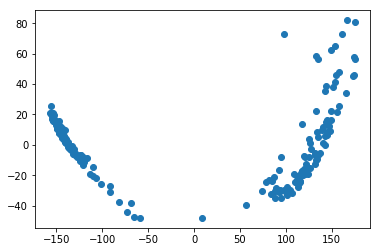

In [18]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
data = np.array(table)
pca = PCA(n_components=2)
coor = pca.fit_transform(data)
x, y = np.array(coor).T
plt.scatter(x, y)
plt.show()

### another approach for visualization clustering, will print edges as well, time consuming

In [42]:
import networkx as nx
dt = [('len', float)]
A = np.array(table)
A = A.view(dt)

G = nx.from_numpy_matrix(A)
G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())),string.ascii_uppercase)))    
G = nx.drawing.nx_agraph.to_agraph(G)
# edges = list(G.edges())
# G.remove_edges_from(edges)
# G.node_attr.update(color="red", style="filled")
G.edge_attr.update(color="white")
G.draw('./out.png', format='png', prog='neato')